# Bibtex to CSV
This is part of the project described in <https://github.com/amchagas/OSH_papers_DB>, check the project readme for more details.

This notebook loads bibtex sources and merges them in a single CSV file.

In [1]:
import os
import pandas as pd
import bibtexparser
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
basePath = Path("..")
dataSourcePath = basePath / 'data' / 'sources'
dataOutPath = basePath / 'data' / 'derived'
figPath = basePath / 'figures'

In [3]:
scieloSource = {
    'paths': [dataSourcePath / x for x in ("scielo.bib",)],
    'col_rename': {
        "type": "ENTRYTYPE",
    },
}
scopusSource = {
    'paths': [dataSourcePath / x for x in ("scopus1.bib", "scopus2.bib")],
    'col_rename': {},
}
wosSource = {
    'paths': [dataSourcePath / x for x in ("wos1.bib", "wos2.bib", "wos3.bib", "wos4.bib")],
    'col_rename': {},
}

In [4]:
def load_bibtext(bibtexSource):
    dfs = []
    for path in bibtexSource['paths']:
        with path.open() as f:
            df = pd.DataFrame(bibtexparser.load(f).entries)
        df['__bibtex_source'] = path.name
        dfs.append(df)
    cdf = pd.concat(dfs, join='outer', ignore_index=True)
    cdf = cdf.rename(columns=bibtexSource['col_rename'])
    return cdf

In [5]:
scieloData = load_bibtext(scieloSource)

In [6]:
scopusData = load_bibtext(scopusSource)

In [7]:
wosData = load_bibtext(wosSource)

In [8]:
allDataList = [scieloData, scopusData, wosData]

In [9]:
allData = pd.concat(allDataList, join='outer', ignore_index=True)
allData = allData.transform(
    lambda x: x # remove "{}" from wos and scielo entries
    .str.strip()
    .str.lstrip('{')
    .str.rstrip('}')
    .str.strip()
)
allData['year'] = allData['year'].astype(int)

In [10]:
allData.to_csv(dataOutPath / "allData.csv")

# All done, now just mess around

In [11]:
print(allData.shape)
print(allData.columns)

(4218, 61)
Index(['url', 'pages', 'crossref', 'month', 'language', 'publisher', 'year',
       'volume', 'author', 'journal', 'title', 'ENTRYTYPE', 'ID',
       '__bibtex_source', 'source', 'document_type', 'abbrev_source_title',
       'isbn', 'keywords', 'author_keywords', 'abstract', 'affiliation',
       'note', 'art_number', 'doi', 'editor', 'correspondence_address1',
       'page_count', 'issn', 'number', 'pubmed_id', 'coden', 'da', 'unique-id',
       'doc-delivery-number', 'journal-iso', 'usage-count-since-2013',
       'usage-count-last-180-days', 'times-cited',
       'number-of-cited-references', 'funding-text', 'funding-acknowledgement',
       'author-email', 'web-of-science-categories', 'research-areas',
       'keywords-plus', 'eissn', 'type', 'address', 'orcid-numbers',
       'article-number', 'researcherid-numbers', 'oa', 'organization',
       'booktitle', 'book-group-author', 'meeting', 'series', 'esi-hot-paper',
       'esi-highly-cited-paper', 'book-author'],
    

In [12]:
article_data = allData.loc[allData["ENTRYTYPE"].eq('article')]
print(article_data.shape)

(2076, 61)


In [13]:
dup_title = article_data.duplicated('title', keep=False)
dup_doi = article_data.duplicated('doi', keep=False)
nan_doi = article_data['doi'].isna()
print(
    dup_title.sum(),
    dup_doi.sum(),
    nan_doi.sum(),
    (dup_title & dup_doi).sum(),
    (dup_title & ~dup_doi).sum(),
)

261 1471 154 256 5


In [14]:
article_data.journal.value_counts()

Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics)    55
SENSORS                                                                                                                                 54
Sensors (Switzerland)                                                                                                                   49
HardwareX                                                                                                                               34
Advances in Intelligent Systems and Computing                                                                                           23
                                                                                                                                        ..
Radio Science                                                                                                                            1
JOURNAL OF ASSISTIVE TECHNO

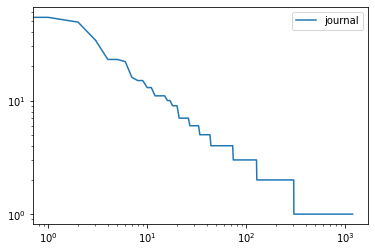

In [15]:
article_data.journal.value_counts().reset_index().plot(loglog=True)

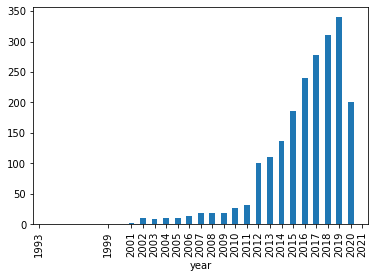

In [16]:
article_data.groupby('year').size().plot.bar()